### Notebook for plotting the national inequality metrics

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import numpy as np
import yaml
import os
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
# Define function combining geopackages
def combine_national_metrics(country_list, model, vuln_curve):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the vulnerability curve usedd (JRC, EXP, or BERN)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", f"{country}",
                                       "inequality_metrics", f"{country}_ADM-0_metrics_{model}-flood_V-{vuln_curve}.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

# Define function combining geopackages
def combine_national_observed_metrics(country_list, model):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the observed dataset used (gfd or google)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", f"{country}",
                                       "inequality_metrics", f"{country}_ADM-0_metrics_{model}-flood.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

# Define function for adjusting quantile ratio
def transform_qr(value):
    if pd.isna(value):
        return value
    elif value == 0:
        return float('inf')
    elif value < 1:
        return -1 / value
    else:
        return value

In [3]:
# Load countries from config file
with open(os.path.join("..", "config", "config.yaml"), "r") as file:
    config = yaml.safe_load(file)
countries = config.get("iso_codes", [])

### Modelled Plots

In [7]:
# Combine data for specific model and vulnerability curve
model = "giri"
vuln = "JRC"
combined_metrics = combine_national_metrics(countries, model, vuln)
# Filter countries (based on the RWI population coverage)
coverage_threshold = 90 # going to use 90% first
combined_metrics = combined_metrics[combined_metrics['Population Coverage (%)'] > coverage_threshold]
# Adjust quantile ratio so that it is multiple (easier to plot)
combined_metrics['QR_transformed'] = combined_metrics['QR'].apply(transform_qr)
combined_metrics.head()

,GID_0,CI,QR,Population,Population Coverage (%),rwi_count,geometry,QR_transformed
0,AGO,0.323805,2.855317,3.327678e+07,97.467367,3693272,"MULTIPOLYGON (((19.89892 -17.87674, 19.89082 -...",2.855317
1,ALB,-0.330966,1.395645,2.861623e+06,97.997917,579814,"MULTIPOLYGON (((20.05408 39.69171, 20.03888 39...",1.395645
2,ARG,-0.009642,1.055260,4.480985e+07,97.600713,5071378,"MULTIPOLYGON (((-68.61305 -52.65108, -68.61341...",1.055260
3,ARM,-0.105670,1.502713,2.804840e+06,98.631105,298066,"MULTIPOLYGON (((45.83188 39.8311, 45.83716 39....",1.502713
5,BDI,0.331646,3.580092,1.221659e+07,99.985418,1635934,"MULTIPOLYGON (((30.04515 -4.25684, 30.04523 -4...",3.580092


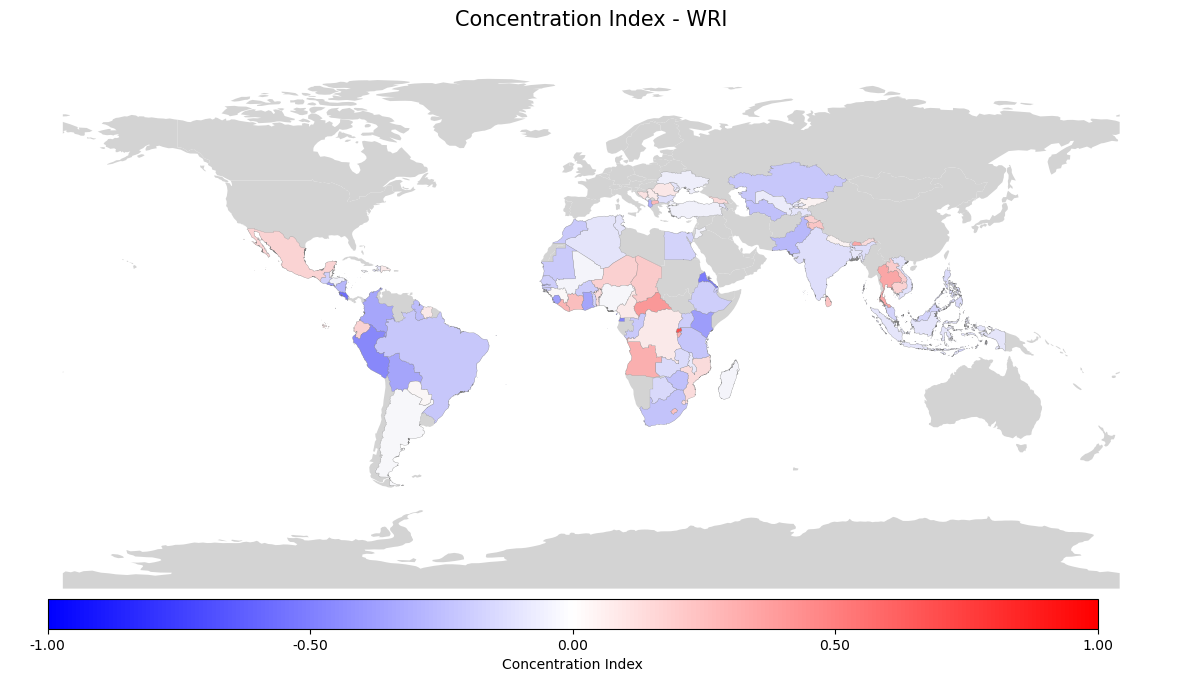

In [8]:
# Plot a map of the metrics
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr
colormap_min = -1
colormap_max = 1
metric = "CI"
label = "Concentration Index"
title = "Concentration Index - WRI"

# Create a copy of original dataframe for mapping
map_df = combined_metrics.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)


    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    
    # Create the colorbar with custom positioning
    cax = fig.add_axes([0.15, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # Create evenly spaced ticks (5 ticks including min and max)
    tick_values = np.linspace(colormap_min, colormap_max, 5)
    cbar.set_ticks(tick_values)
    # Format the tick labels to have fewer decimal places
    cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    cbar.set_label(label)

# Add title explicitly to the ax object, not using plt.title
ax.set_title(title, fontsize=15, pad=20)

# Turn off the axis
ax.set_axis_off()

plt.show()

### Observed Plots

In [24]:
# Combine data for specific model and vulnerability curve
model = "gfd"
combined_metrics = combine_national_observed_metrics(countries, model)
# Filter countries (based on the RWI population coverage)
coverage_threshold = 90 # going to use 90% first
combined_metrics = combined_metrics[combined_metrics['Population Coverage (%)'] > coverage_threshold]
# Adjust quantile ratio so that it is multiple (easier to plot)
combined_metrics['QR_transformed'] = combined_metrics['QR'].apply(transform_qr)
combined_metrics.head()

Error processing ARG: ../data/results/social_flood/ARG/inequality_metrics/ARG_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing BRA: ../data/results/social_flood/BRA/inequality_metrics/BRA_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing COD: ../data/results/social_flood/COD/inequality_metrics/COD_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing COL: ../data/results/social_flood/COL/inequality_metrics/COL_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing DZA: ../data/results/social_flood/DZA/inequality_metrics/DZA_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing ETH: ../data/results/social_flood/ETH/inequality_metrics/ETH_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing IDN: ../data/results/social_flood/IDN/inequality_metrics/IDN_ADM-0_metrics_gfd-flood.gpkg: No such file or directory
Error processing IND: ../data/results/social_flood/IND/inequal

,GID_0,CI,QR,Population,Population Coverage (%),rwi_count,geometry,QR_transformed
0,AGO,-0.258866,2.595525,3.327678e+07,97.467367,3693272,"MULTIPOLYGON (((19.89892 -17.87674, 19.89082 -...",2.595525
1,ALB,-0.040754,3.981791,2.861623e+06,97.997917,579814,"MULTIPOLYGON (((20.05408 39.69171, 20.03888 39...",3.981791
2,ARM,-0.289397,1.681818,2.804840e+06,98.631105,298066,"MULTIPOLYGON (((45.83188 39.8311, 45.83716 39....",1.681818
4,BDI,-0.128003,1.215909,1.221659e+07,99.985418,1635934,"MULTIPOLYGON (((30.04515 -4.25684, 30.04523 -4...",1.215909
5,BEN,-0.203393,3.927688,1.255592e+07,99.288102,2027426,"MULTIPOLYGON (((1.85819 6.28514, 1.85819 6.284...",3.927688


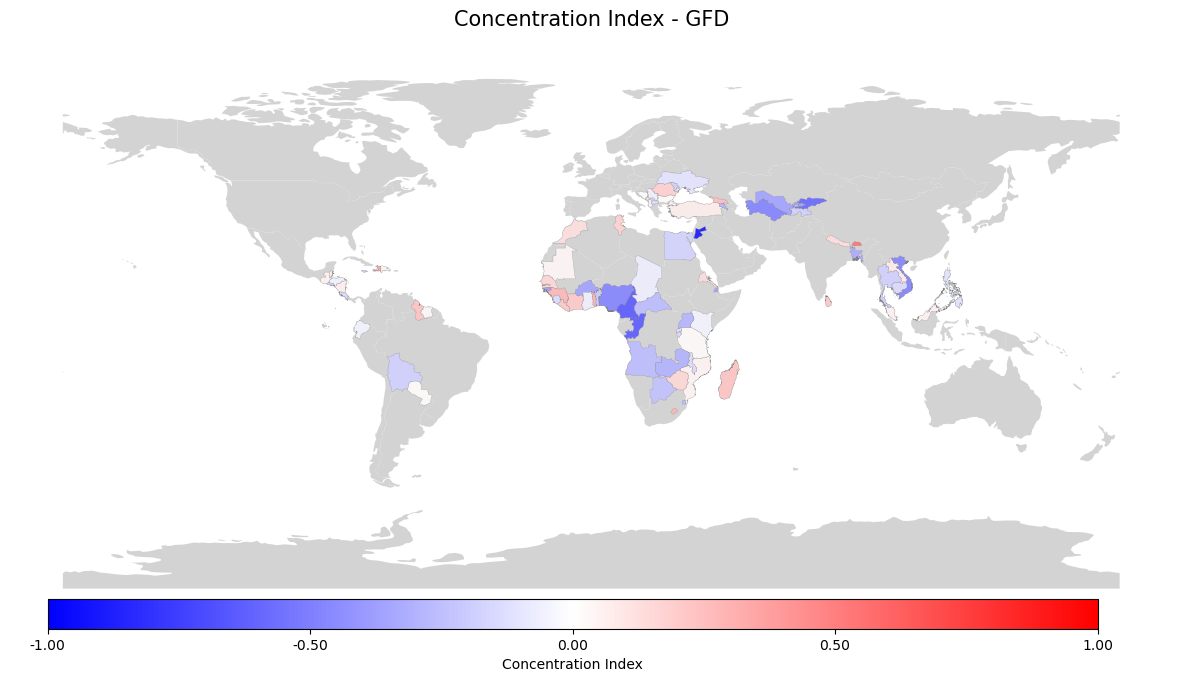

In [25]:
# Plot a map of the metrics
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr
colormap_min = -1
colormap_max = 1
metric = "CI"
label = "Concentration Index"
title = "Concentration Index - GFD"

# Create a copy of original dataframe for mapping
map_df = combined_metrics.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)


    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    
    # Create the colorbar with custom positioning
    cax = fig.add_axes([0.15, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # Create evenly spaced ticks (5 ticks including min and max)
    tick_values = np.linspace(colormap_min, colormap_max, 5)
    cbar.set_ticks(tick_values)
    # Format the tick labels to have fewer decimal places
    cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    cbar.set_label(label)

# Add title explicitly to the ax object, not using plt.title
ax.set_title(title, fontsize=15, pad=20)

# Turn off the axis
ax.set_axis_off()

plt.show()